In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import aftfore

## Prepare data

In [2]:
Data = pd.read_csv("sample.dat", header=None, delim_whitespace=True)
Data.columns = ["T", "Mag"]
display(Data)

# `Data` is a `pd.DataFrame` with columns "T" and "Mag". 
# "T" represents the elapsed time [days] from the main shock for each event.
# "Mag" represents the magnitude of each event.
# The first event `Data.iloc[0, :]` is a main shock, and following events `Data.iloc[1:, :]` are the aftershocks.
# This sample data contain a main shock and its aftershocks in the first day."

,T,Mag
0,0.000000,7.3
1,0.012540,4.2
2,0.021659,4.7
3,0.023037,4.3
4,0.023690,4.0
...,...,...
1111,0.998078,2.5
1112,0.998333,2.1
1113,0.998622,2.6
1114,0.998694,2.7


## Estimating the model parameters

In [3]:
itv = [0, 0.5] # the time interval of training data. In this case, we use the aftershocks in an interval of [0, 0.5] days for estimating the parameters of a forecast model.
model = aftfore.model()
param = model.mcmc(Data, itv)

print('MAP estimate: ')
display(param['para_mle'])
print()
print('MCMC parameters: ')
display(param['para_mcmc'])

MAP estimate: 


beta     2.039063
mu1     -0.016813
sigma    0.322108
k        0.025048
p        1.047420
c        0.201617
Name: 0, dtype: float64


MCMC parameters: 


,beta,mu1,sigma,k,p,c
0,2.039063,-0.016813,0.322108,0.025048,1.047420,0.201617
100,2.046123,0.005903,0.320470,0.024552,1.043972,0.209482
200,2.080592,-0.040241,0.319984,0.023276,0.979859,0.273058
300,2.045417,-0.026777,0.330047,0.021808,1.038358,0.177271
400,2.150224,-0.028467,0.313104,0.015364,1.053512,0.225011
...,...,...,...,...,...,...
99500,2.149994,-0.011791,0.315592,0.017011,1.055348,0.256571
99600,2.155349,0.016786,0.318354,0.017637,1.054885,0.245576
99700,2.154725,0.055636,0.332271,0.017003,0.994156,0.202811
99800,2.188000,-0.001524,0.321585,0.013285,1.077205,0.245258


## Prediction

In [4]:
itv_forecast = [0.5, 1.0] # the time interval for forecasting. In this example, In this case we are going to forecast the earthquakes in an interval of [0.5, 1.0] days. 
prediction = model.predict(itv_forecast)
display(pd.DataFrame(prediction["pred"]).iloc[50:60])

# For example, the row of index 50 in the below table represents the prediction of earthaquakes with M >= 5.95 in an time interval [0.5, 1.0] (day).
# The expected number is 0.212248, and the 95% confidence interval is [0, 2].
# The probability of one or more events with M >= 5.95 is 0.213192.

,expected_number,lower_bound_95%_interval,upper_bound_95%_interval,probability_of_one_or_more_events,mag
50,0.212248,0,2,0.198772,5.95
51,0.173097,0,1,0.166462,6.05
52,0.141167,0,1,0.138923,6.15
53,0.115127,0,1,0.115606,6.25
54,0.093891,0,1,0.095973,6.35
55,0.076572,0,1,0.079518,6.45
56,0.062447,0,1,0.065778,6.55
57,0.050928,0,1,0.054340,6.65
58,0.041534,0,1,0.044842,6.75
59,0.033872,0,1,0.036973,6.85


(4.0, 8.0)

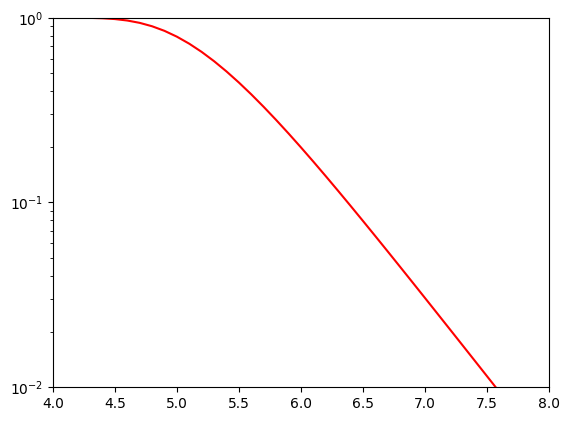

In [5]:
# probability forecast

df_pred = pd.DataFrame(prediction["pred"])

plt.semilogy(df_pred["mag"]+0.05, df_pred["probability_of_one_or_more_events"], 'r-')

plt.ylim([0.01, 1])
plt.xlim([4,8])

## Evaluation

In [6]:
prediction = aftfore.model.add_obs_num(prediction, Data)
display(pd.DataFrame(prediction["pred"]).iloc[30:40])

# The observed number of earthquakes is added to the DataFrame.

,expected_number,lower_bound_95%_interval,upper_bound_95%_interval,probability_of_one_or_more_events,mag,observed_number
30,12.530021,5,22,0.999974,3.95,7
31,10.218718,4,19,0.999835,4.05,4
32,8.333761,3,16,0.999254,4.15,4
33,6.796506,2,14,0.997399,4.25,3
34,5.542814,1,12,0.992693,4.35,3
35,4.520380,1,10,0.982822,4.45,3
36,3.686545,0,9,0.965155,4.55,3
37,3.006521,0,8,0.937443,4.65,3
38,2.451934,0,7,0.898489,4.75,0
39,1.999648,0,6,0.848515,4.85,0


(2.0, 8.0)

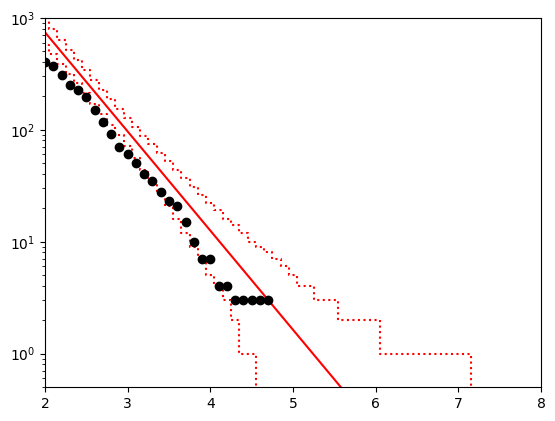

In [7]:
# compare forecast and prediction for the earthquake number.

df_pred = pd.DataFrame(prediction["pred"])
x = np.array([df_pred["mag"], df_pred["mag"]+0.1]).T.flatten()
y_l = np.array([ df_pred["lower_bound_95%_interval"],  df_pred["lower_bound_95%_interval"]]).T.flatten()
y_u = np.array([ df_pred["upper_bound_95%_interval"],  df_pred["upper_bound_95%_interval"]]).T.flatten()


plt.semilogy(df_pred["mag"]+0.05, df_pred["expected_number"], 'r-')
plt.semilogy(x, y_l, 'r:')
plt.semilogy(x, y_u, 'r:')
plt.semilogy(df_pred["mag"]+0.05, df_pred["observed_number"], "ko")

plt.ylim([0.5, 1000])
plt.xlim([2,8])